In [1]:
!pip install dionysus
!pip install zarr
!pip install gudhi
!pip install POT
!pip install xarray

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
from google.colab import files
import os

drive.mount('/content/drive',force_remount=True)
os.chdir("/content/drive/My Drive/NASA")
!ls -ltr
path = os.getcwd()

Mounted at /content/drive
total 14439
-rw------- 1 root root    1667 Oct  5 18:53  zigzagtools.py
-rw------- 1 root root   85452 Oct  5 18:53  zigzag_PD_eps_1.pdf
-rw------- 1 root root       0 Oct  5 18:53  VRrips.pk
-rw------- 1 root root  133051 Oct  5 18:53  PIs_labelled_modulo_month.pdf
-rw------- 1 root root  132779 Oct  5 18:53  PIs_labelled_modulo_month_1.pdf
-rw------- 1 root root  105850 Oct  5 18:53  PIs_labelled_modulo_month_0.pdf
-rw------- 1 root root  127787 Oct  5 18:53  PIs_labelled_1.pdf
-rw------- 1 root root  116243 Oct  5 18:53  PIs_labelled_0.pdf
-rw------- 1 root root  253295 Oct  5 18:53  PClouds.pdf
-rw------- 1 root root 1682280 Oct  5 18:53  Merra_t2m_freudenthal_Oct_2022.ipynb
-rw------- 1 root root  324306 Oct  5 18:53  Merra_t2m_freudenthal.ipynb
-rw------- 1 root root  323836 Oct  5 18:53  MERRA2_t2m_GP_20210201-20210228.nc
-rw------- 1 root root 1690684 Oct  5 18:53  MERRA2_t2m_CONUS_20210201-20210228.nc
-rw------- 1 root root  527019 Oct  5 18:53  MERRA

In [3]:
import zarr
import seaborn as sns
import numpy as np
import scipy
import pandas as pd
import dionysus as d
import matplotlib.pyplot as plt
from gudhi.wasserstein.barycenter import lagrangian_barycenter
import gudhi.wasserstein
import xarray as xr
sns.set_theme()

In [4]:
def extract_PD_arrays_with_freudenthal_triangulation(data, lower =240., infinity = 300.): # lower, inf may change
    
    f_lower_star = d.fill_freudenthal(np.array(data, dtype='float64'))
    p = d.homology_persistence(f_lower_star)
    dgms = d.init_diagrams(p, f_lower_star)
    birth0=np.array([dgm.birth for dgm in dgms[0]])
    death0=np.array([dgm.death for dgm in dgms[0]])
    death0[death0==np.Infinity] = infinity 
    birth1=np.array([dgm.birth for dgm in dgms[1]])
    death1=np.array([dgm.death for dgm in dgms[1]])
    death1[death1==np.Infinity] = infinity
    
    return [[birth0,death0],[birth1,death1]]


def plot_Dionysus_PDs(pd0_array, pd1_array, titles, lower_bound=240, upper_bound=300):
    fig = plt.figure(figsize=(30,20))
    nday = len(pd0_array)
    for iday in np.arange(nday):
        ax = fig.add_subplot(4,7,1+iday)
        ax.scatter(pd0_array[iday][0], pd0_array[iday][1], color='r', s=5, label = '0')
        ax.scatter(pd1_array[iday][0], pd1_array[iday][1], marker='^', s=5,
               facecolors='none', edgecolor='blue', label = '1')
        
        ax.plot(np.arange(lower_bound, upper_bound), np.arange(lower_bound, upper_bound), '-', color='grey', lw=0.5)
        ax.set_xlim([lower_bound, upper_bound])
        ax.set_ylim([lower_bound, upper_bound])
        ax.set_title(titles[iday])
        ax.set_xlabel('Birth')
        ax.set_ylabel('Death')
    plt.savefig("pds.pdf",bbox_inches='tight')
    plt.show()   

In [5]:
fname = 'MERRA2_t2m_GP_20210201-20210228.nc'
ds = xr.open_dataset(fname)
data = ds['t2m'].squeeze()
nday = 28
lon = ds.lon
lat = ds.lat
#print(data.min(), data.max())
#print (np.shape(data[0,:]))
#print (data[0,:])

print (np.array(data[0,:, :]))

[[288.49606323 289.03155518 287.08218384 ... 282.00143433 282.7444458
  283.34893799]
 [286.56442261 286.54849243 284.95831299 ... 281.21334839 281.68276978
  281.62319946]
 [283.40982056 283.60250854 282.26071167 ... 280.56246948 280.49966431
  280.5128479 ]
 ...
 [272.62832642 272.45513916 272.47271729 ... 265.21435547 265.72332764
  265.02468872]
 [272.60656738 272.92019653 272.78347778 ... 264.9175415  265.2008667
  264.56951904]
 [275.76651001 275.35919189 274.49002075 ... 264.76290894 264.65261841
  263.64828491]]


In [6]:
innerSizeWindow=7
lower=int(np.floor(innerSizeWindow/2))
upper=int(np.ceil(innerSizeWindow/2))

#freudenthal_complex = []
pd0 = []
pd1 = []

#freudenthal_complex_union = []
pd0_union = []
pd1_union = []
for iday in np.arange(nday):
    # Build freudenthal_triangulation for individual day 
    p0, p1 = extract_PD_arrays_with_freudenthal_triangulation(data[iday,:])
    #freudenthal_complex.append(cc)
    pd0.append(p0)
    pd1.append(p1)
    # Build freudenthal_triangulation for the union of two consecutive days
    #if iday != nday-1:
    #p0, p1 = extract_PD_arrays_with_freudenthal_triangulation(0.5*data[iday,:]+0.5*data[iday+1,:])
    p0, p1 = extract_PD_arrays_with_freudenthal_triangulation(data[iday,:])
    
    #freudenthal_complex_union.append(cc)
    pd0_union.append(p0)
    pd1_union.append(p1)


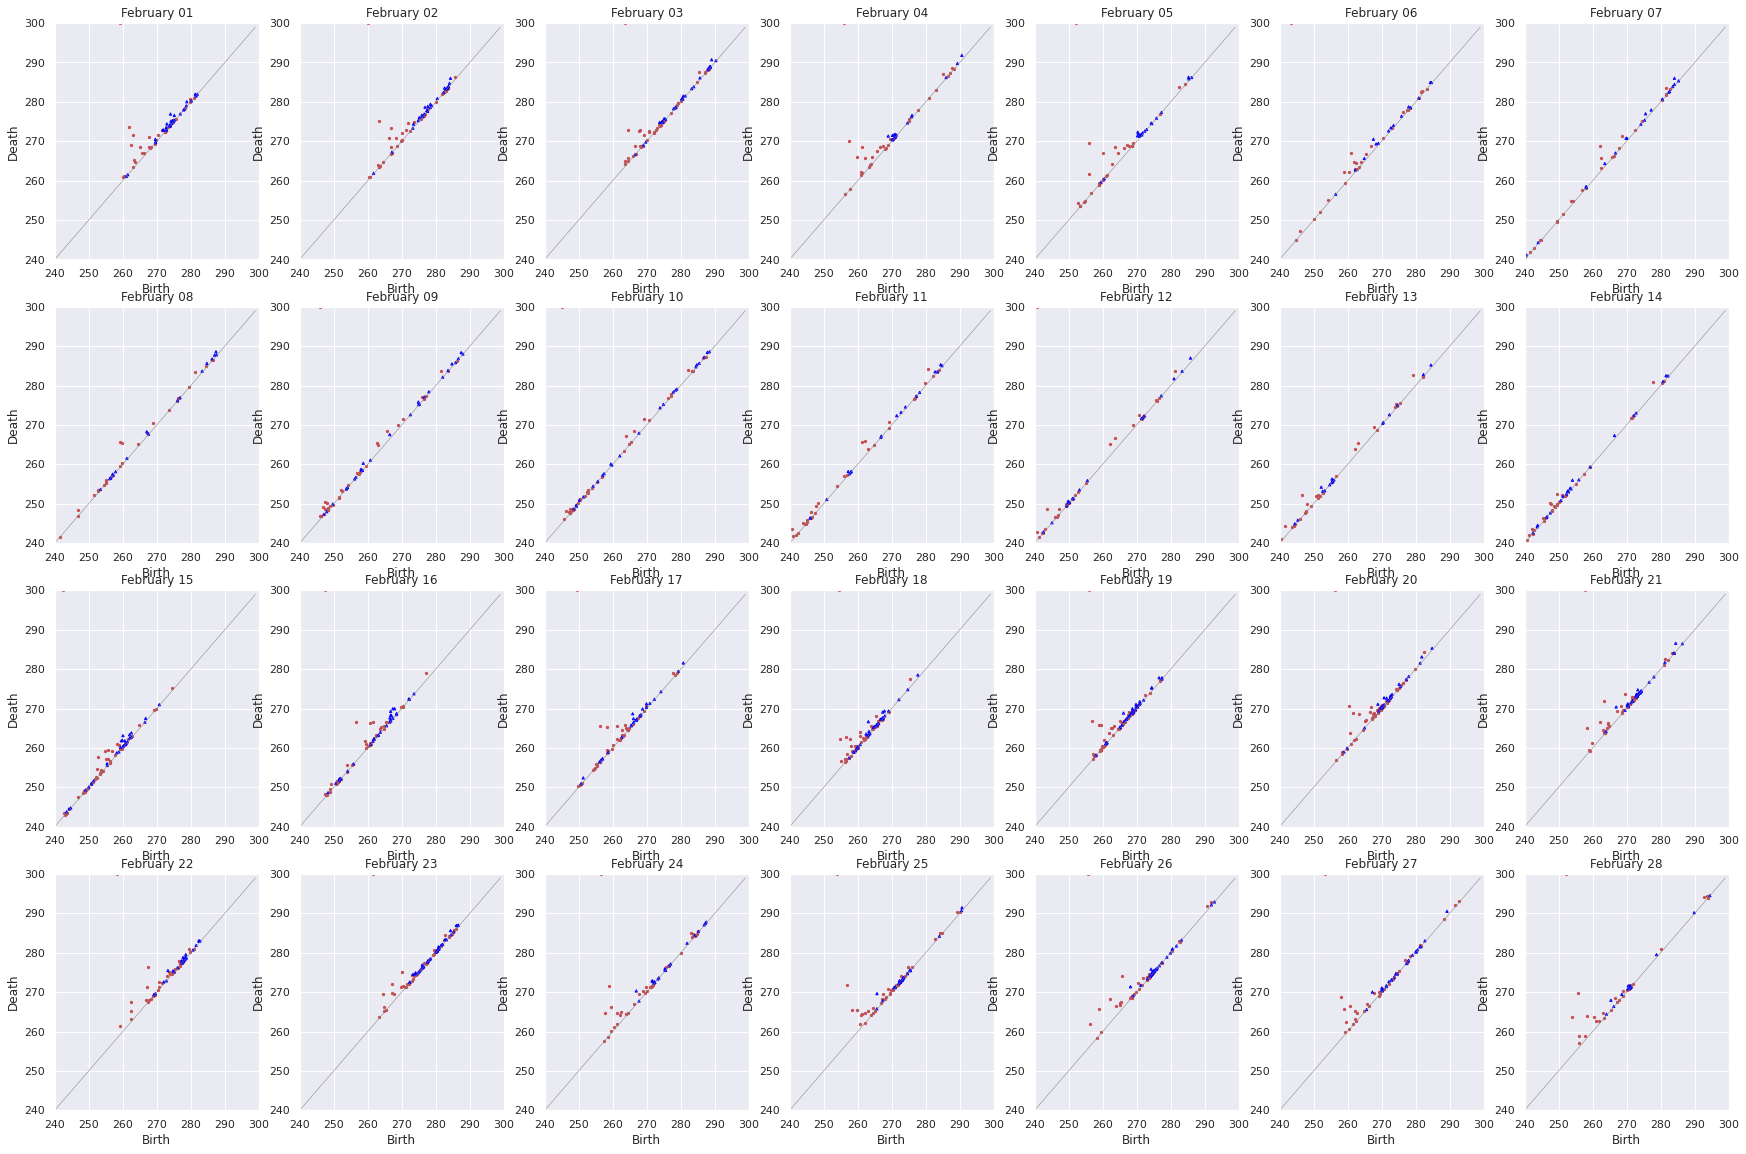

In [7]:
titles = ['February %02d' %(iday+1) for iday in np.arange(nday)]
plot_Dionysus_PDs(pd0_union, pd1_union, titles)

In [8]:
coldLabel=[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

PDList = []
for i in pd0_union:
    temp = np.vstack((i[0], i[1])).T
    PDList.append(temp)

NoColdPD = []
ColdPD = []
for j in range(len(PDList)):
    if coldLabel[j] == 0:
        NoColdPD.append(PDList[j])
    elif coldLabel[j] == 1:
        ColdPD.append(PDList[j])
    else:
        print ('Label went wrong')


baryCenterNoCold = lagrangian_barycenter(pdiagset=NoColdPD, init=None)
baryCenterCold = lagrangian_barycenter(pdiagset=ColdPD, init=None)

maxIndex1 = 0
maxDis1 = 0
for i in range(len(NoColdPD)):
    tempDis1 = gudhi.wasserstein.wasserstein_distance(NoColdPD[i], baryCenterCold, order=2)
    if tempDis1 > maxDis1:
        maxDis1 = tempDis1
        maxIndex1 = i
NoColdFlag = NoColdPD[maxIndex1]

maxIndex2 = 0
maxDis2 = 0
for i in range(len(ColdPD)):
    tempDis2 = gudhi.wasserstein.wasserstein_distance(ColdPD[i], baryCenterNoCold, order=2)
    if tempDis2 > maxDis2:
        maxDis2 = tempDis2
        maxIndex2 = i
ColdFlag = ColdPD[maxIndex2]


dis2NoCold = []
dis2Cold = []
for pd in PDList:
    d1 = gudhi.wasserstein.wasserstein_distance(pd, ColdFlag, order=2)
    d2 = gudhi.wasserstein.wasserstein_distance(pd, NoColdFlag, order=2)
    dis2NoCold.append(d2)
    dis2Cold.append(d1)

normalizeDis2Cold = []
for d in dis2Cold:
    temp = (d - min(dis2Cold))/(max(dis2Cold) - min(dis2Cold))
    normalizeDis2Cold.append(temp)

AttributeError: ignored

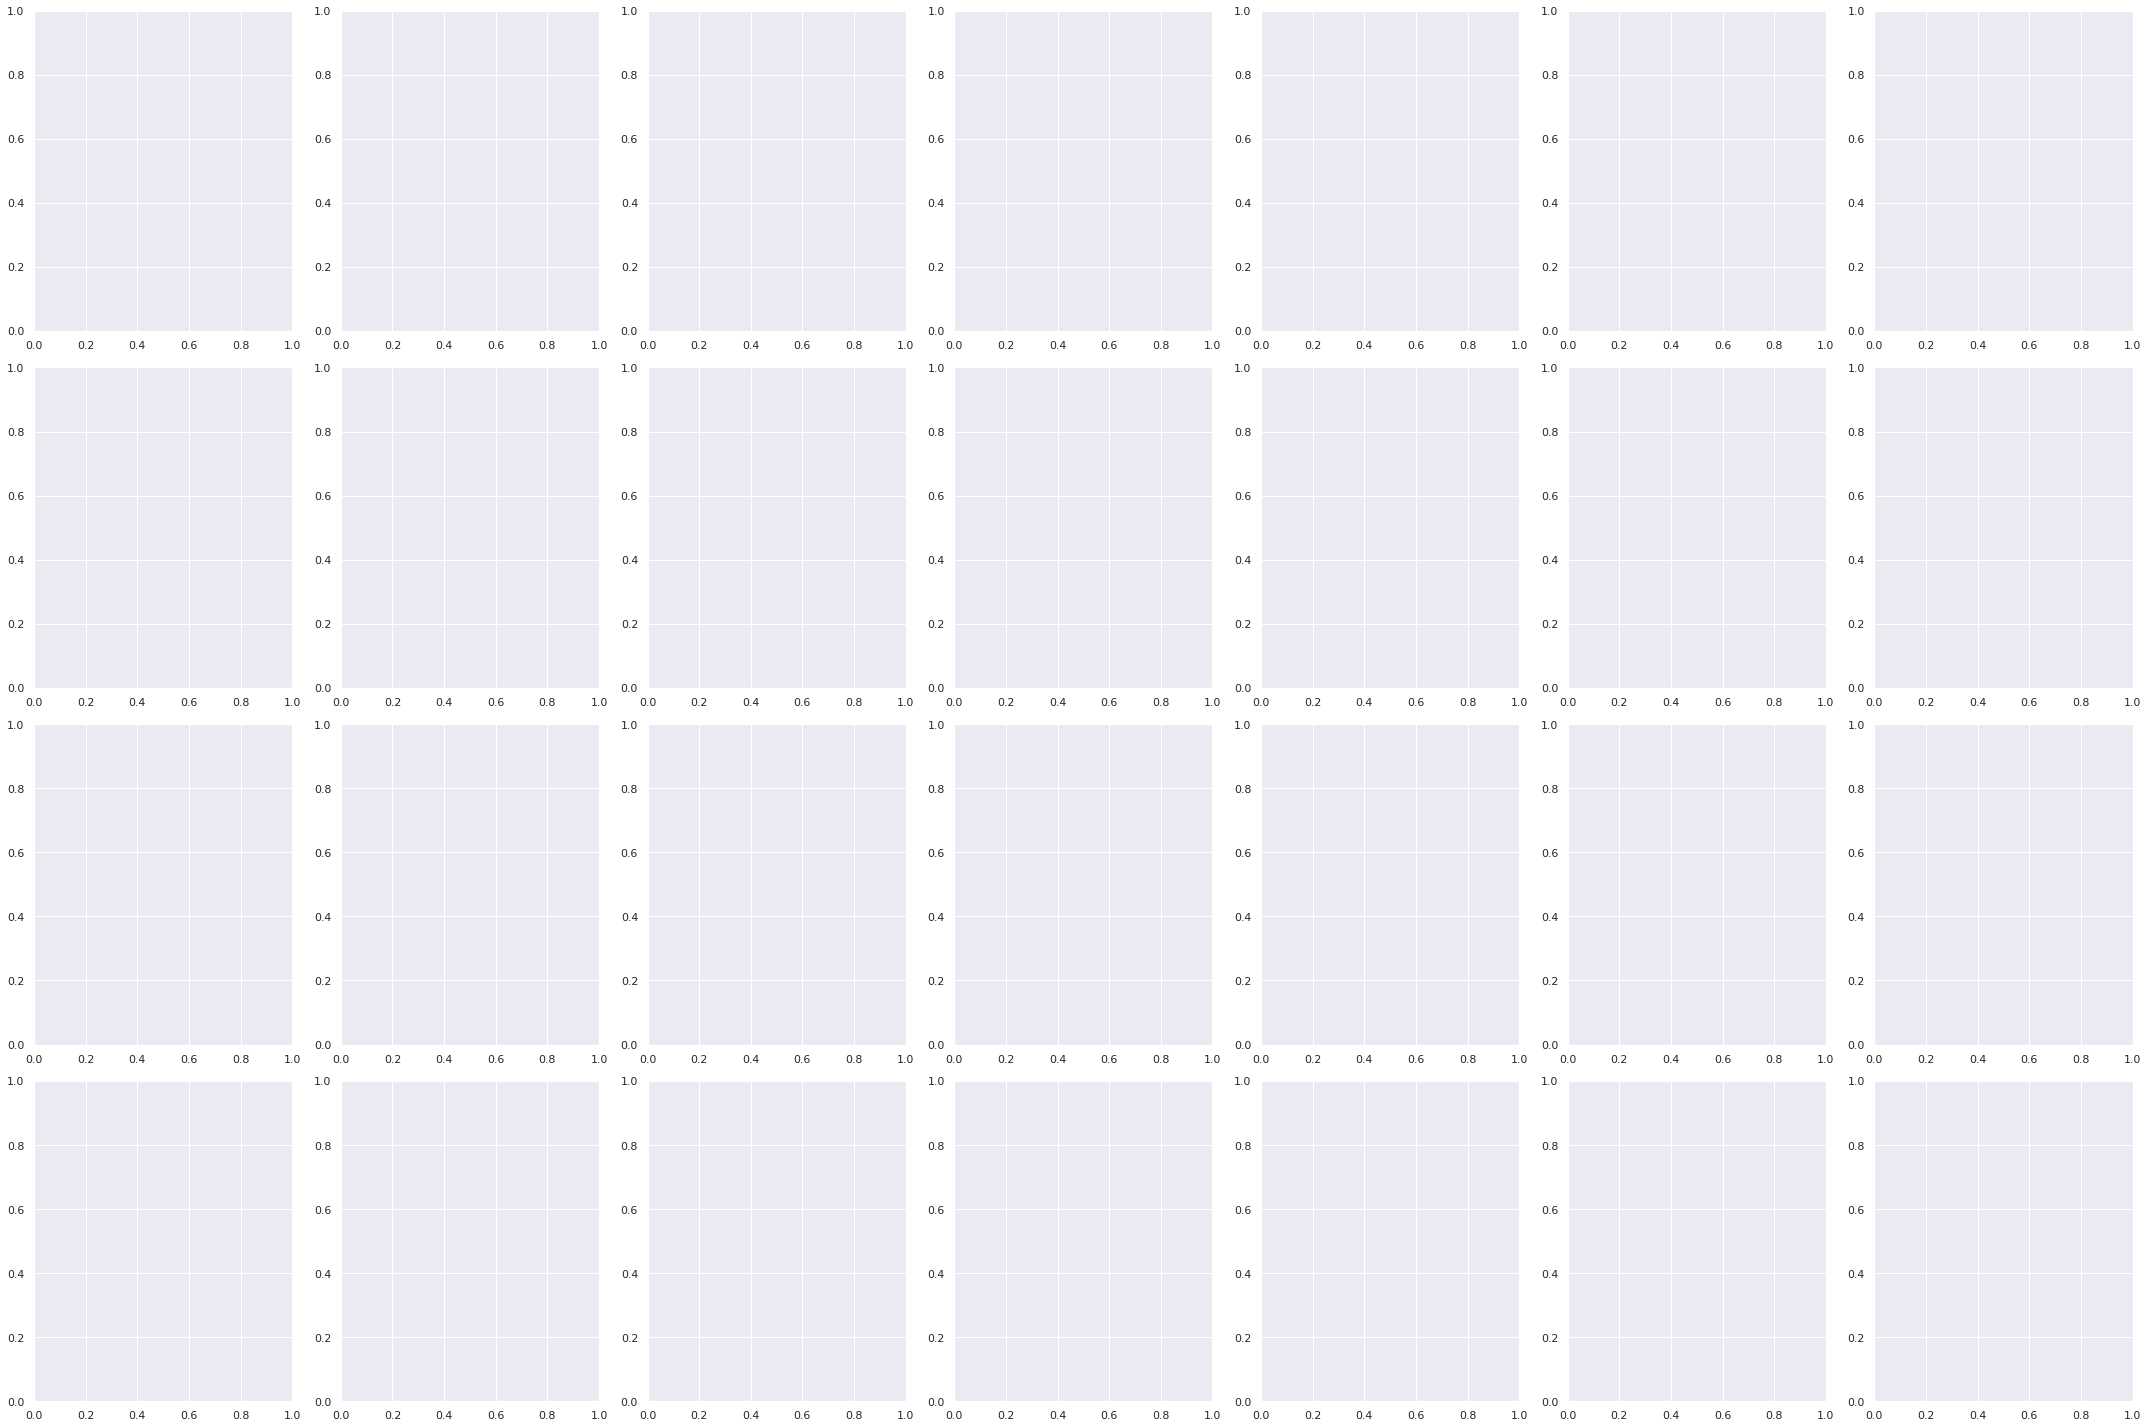

In [9]:
fig, axs = plt.subplots(4, 7, figsize=(30, 20))

for i in range(4):
    for j in range(7):

        lower_bound = 240
        upper_bound = 300

        plt.tight_layout()

        p0, p1 = extract_PD_arrays_with_freudenthal_triangulation(data[i*7 + j,:])
        axs[i, j].scatter(p0[0], p0[1], marker='^', s=5, facecolors='none', edgecolor='blue', label = 'Dimension 1')
        axs[i, j].plot(np.arange(lower_bound, upper_bound), np.arange(lower_bound, upper_bound), '-', color='grey', lw=0.5)

        #axs[i, j].title.set_text('Distance to No Cold: {0:.3f}'.format(dis2NoCold[i*7 + j]))
        axs[i, j].title.set_text('Distance to Cold: {0:.3f}'.format(dis2Cold[i*7 + j]))

plt.show()

# Next, Use both dim0 and dim1

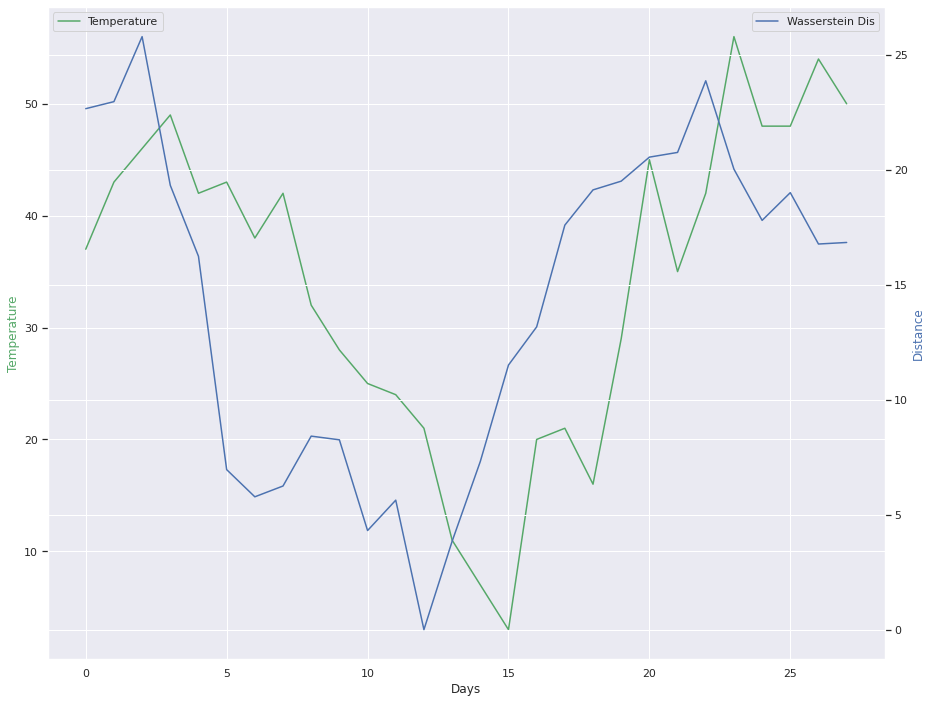

In [35]:
meanFebTemp = [37, 43, 46, 49, 42, 43, 38, 42, 32, 28, 25, 24, 21, 11, 7, 3, 20, 21, 16, 29, 45, 35, 42, 56, 48, 48, 54, 50]

fig, axs = plt.subplots(figsize=(15, 12))

axs.plot(meanFebTemp, 'g-', label='Temperature')

axs2 = axs.twinx()
axs2.plot(dis2Cold, 'b-', label='Wasserstein Dis')

axs.legend(loc="upper left")
axs2.legend(loc="upper right")

axs.set_xlabel('Days')
axs.set_ylabel('Temperature', color='g')
axs2.set_ylabel('Distance', color='b')

plt.show()

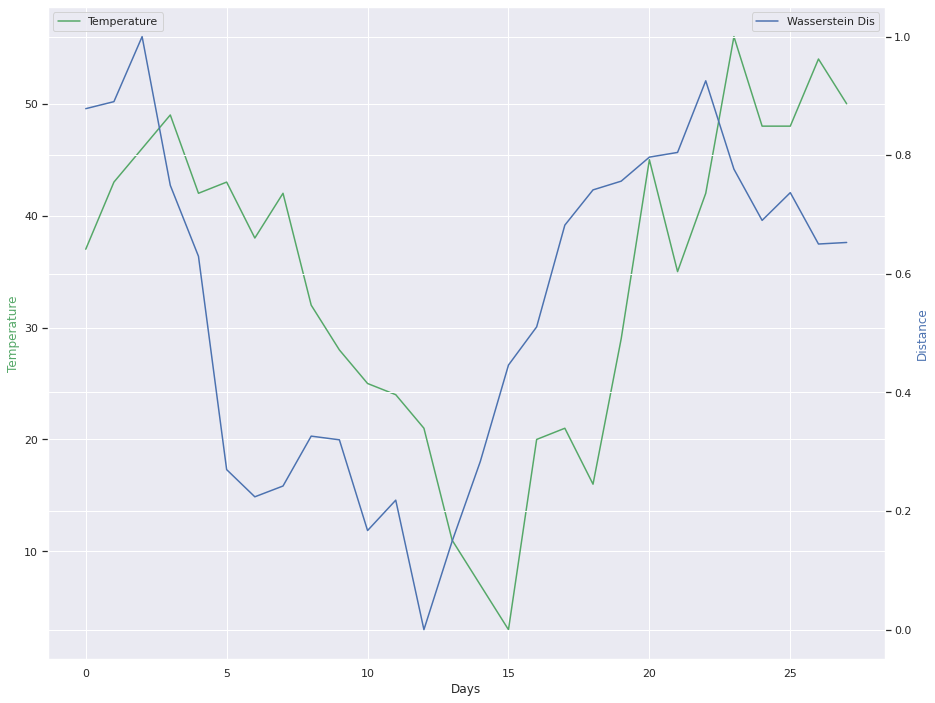

In [36]:
normalizeDis2Cold = []
for d in dis2Cold:
    temp = (d - min(dis2Cold))/(max(dis2Cold) - min(dis2Cold))
    normalizeDis2Cold.append(temp)

meanFebTemp = [37, 43, 46, 49, 42, 43, 38, 42, 32, 28, 25, 24, 21, 11, 7, 3, 20, 21, 16, 29, 45, 35, 42, 56, 48, 48, 54, 50]

fig, axs = plt.subplots(figsize=(15, 12))

axs.plot(meanFebTemp, 'g-', label='Temperature')

axs2 = axs.twinx()
axs2.plot(normalizeDis2Cold, 'b-', label='Wasserstein Dis')

axs.legend(loc="upper left")
axs2.legend(loc="upper right")

axs.set_xlabel('Days')
axs.set_ylabel('Temperature', color='g')
axs2.set_ylabel('Distance', color='b')

plt.show()

AttributeError: ignored

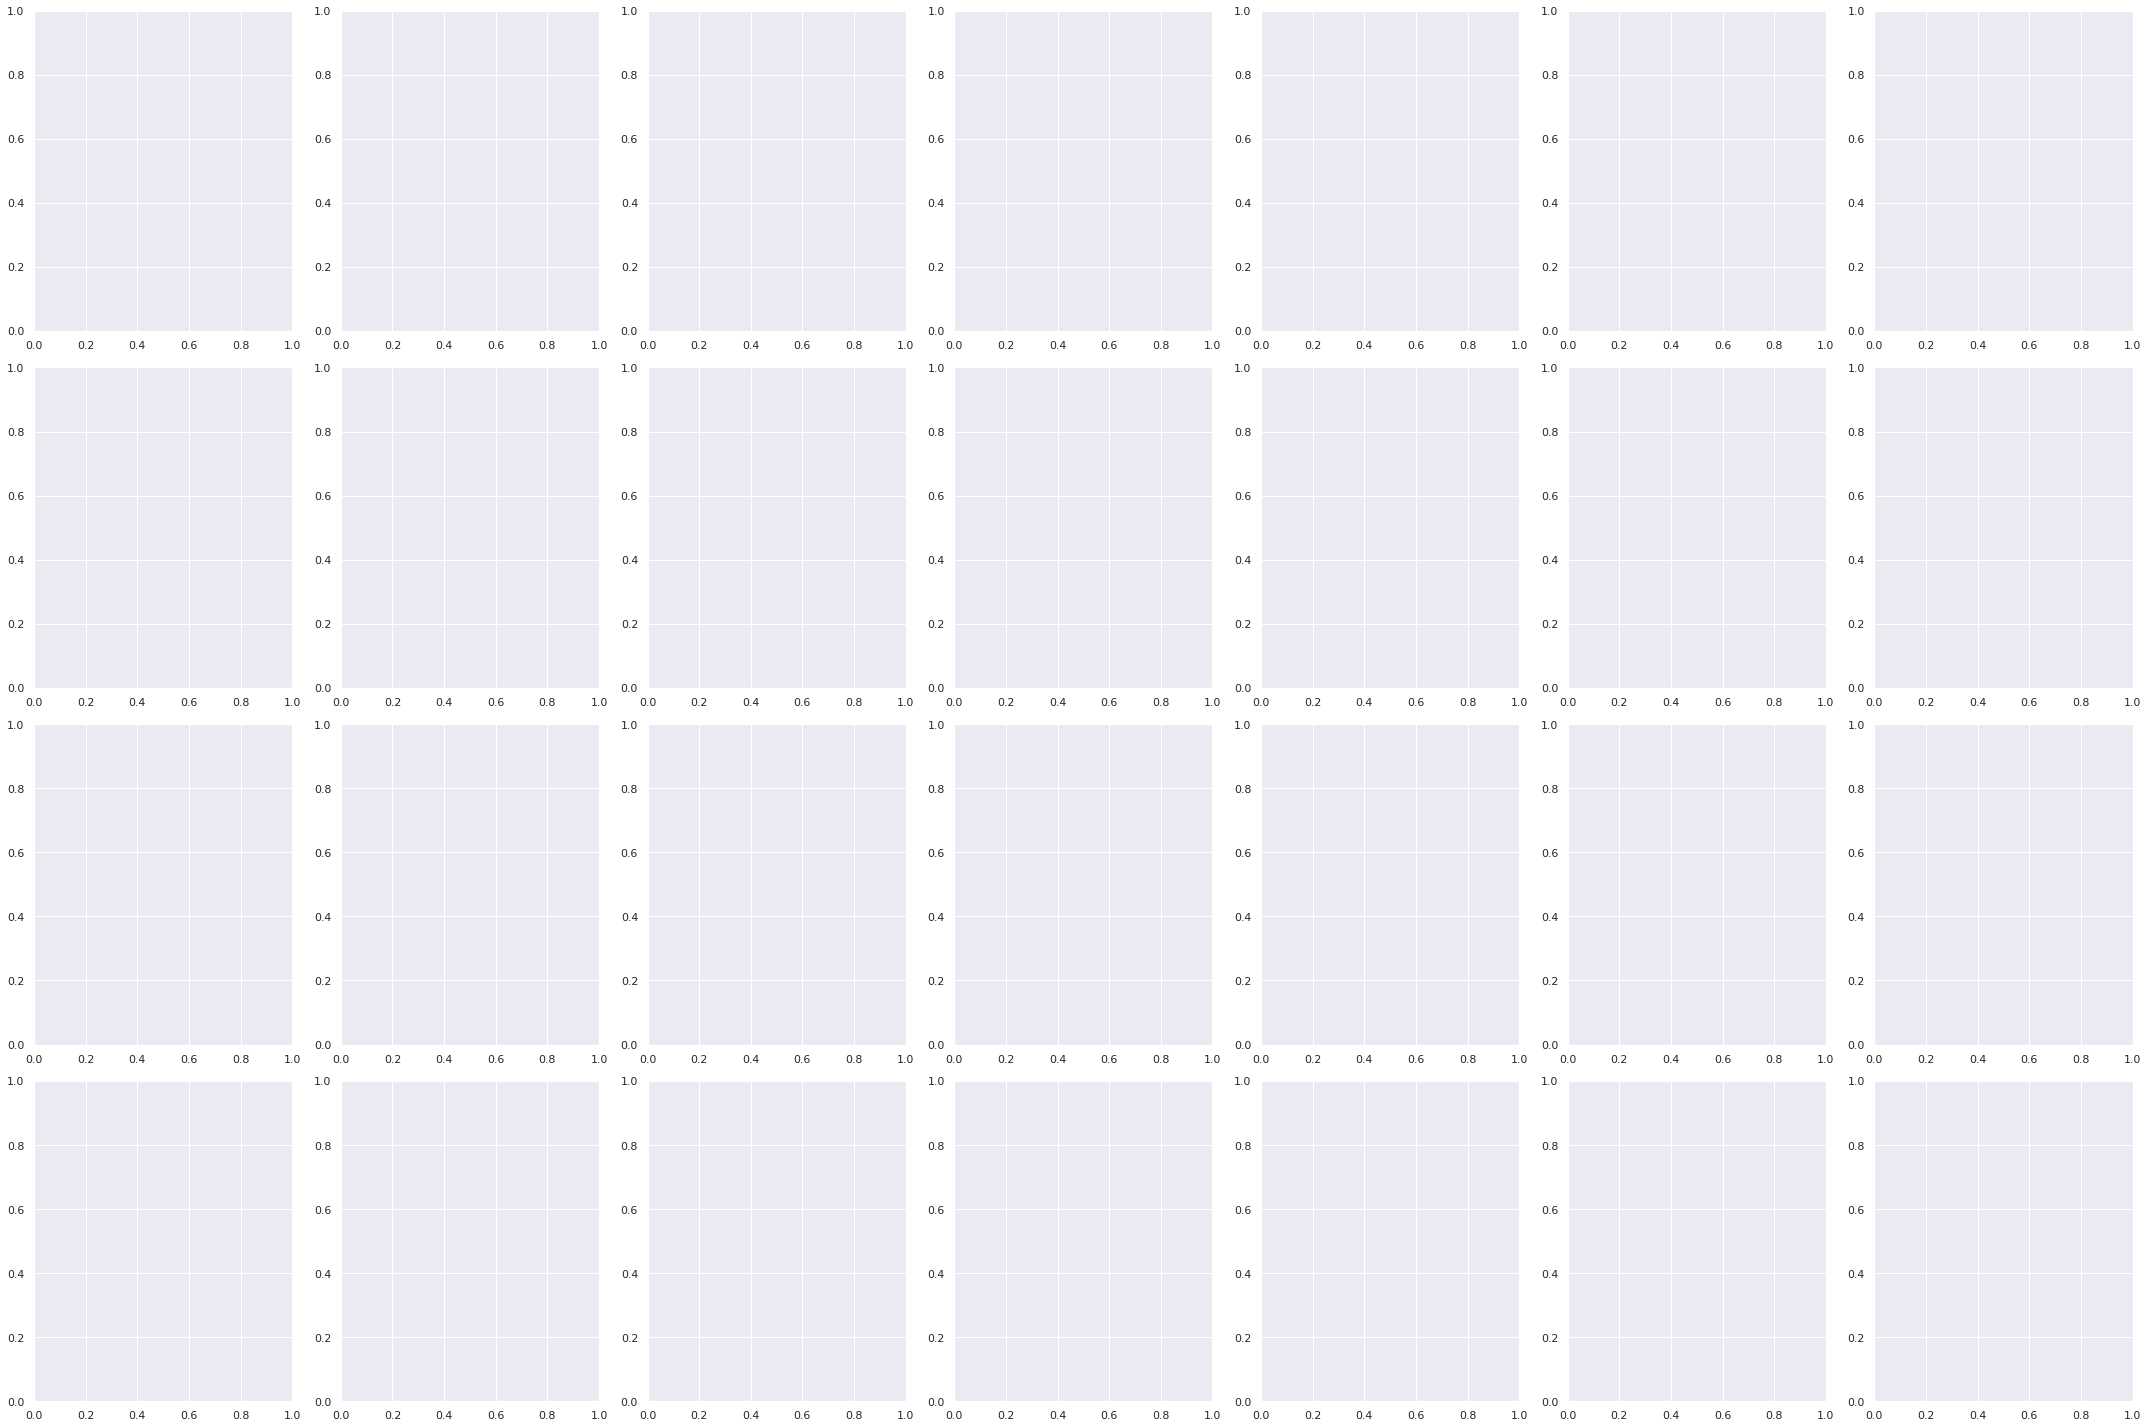

In [37]:
fig, axs = plt.subplots(4, 7, figsize=(30, 20))

for i in range(4):
    for j in range(7):

        lower_bound = 240
        upper_bound = 300

        plt.tight_layout()

        p0, p1 = extract_PD_arrays_with_freudenthal_triangulation(data[i*7 + j,:])
        axs[i, j].scatter(p0[0], p0[1], marker='^', s=5, facecolors='none', edgecolor='blue', label = 'Dimension 1')
        axs[i, j].plot(np.arange(lower_bound, upper_bound), np.arange(lower_bound, upper_bound), '-', color='grey', lw=0.5)

        #axs[i, j].title.set_text('Distance to No Cold: {0:.3f}'.format(dis2NoCold[i*7 + j]))
        axs[i, j].title.set_text('Certainty of cold front: {0:.3f}'.format(normalizeDis2Cold[i*7 + j]))

plt.show()
